## Importation des bibliothèques

In [1]:
import os
import math
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetV2M
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image

2024-03-15 12:39:33.176775: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-15 12:39:33.740668: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-15 12:39:34.538267: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-15 12:39:35.599297: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/tmp/ipykernel_86412/405349110.py:13: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import HyperModel


In [2]:
data_dir = 'data/photos_raw/'

### CNN

## Chargement du modèle

In [3]:
# Importation du modèle EfficientNetV2M pré-entraîné sur ImageNet
base_model = EfficientNetV2M(include_top=False, weights='imagenet', input_shape=(480, 480, 3))

# Désactivation de l'entraînement pour toutes les couches du modèle de base
for layer in base_model.layers:
    layer.trainable = False

# Création d'une couche d'aplatissement pour convertir les données en un vecteur unidimensionnel
flat1 = Flatten()(base_model.output)

# Ajout d'une couche dense avec 1024 neurones et une fonction d'activation ReLU
class1 = Dense(1024, activation='relu')(flat1)

# Couche de sortie avec une activation softmax pour la classification multi-classes (food, drink, other)
output = Dense(3, activation='softmax')(class1)

# Création du modèle en spécifiant les entrées et les sorties
model = Model(inputs=base_model.input, outputs=output)

# Compilation du modèle avec l'optimiseur Adam, la perte de catégorisation croisée et la métrique de précision
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

## Preparation des données

In [4]:
# Création d'un générateur de données pour l'entraînement avec une validation de 20%
train_datagen = ImageDataGenerator(validation_split=0.2)

# Création d'un générateur de lot pour les données d'entraînement à partir du répertoire spécifié
train_generator = train_datagen.flow_from_directory(
    data_dir,  # Répertoire contenant les données
    target_size=(480, 480),  # Redimensionnement des images à la taille spécifiée
    batch_size=32,  # Taille du lot
    class_mode='categorical',  # Mode de classification (dans ce cas, catégorique pour plusieurs classes)
    subset='training',  # Utilisation du sous-ensemble d'entraînement
    shuffle=True  # Mélange aléatoire des données à chaque époque
)

# Création d'un générateur de lot pour les données de validation à partir du même répertoire
validation_generator = train_datagen.flow_from_directory(
    data_dir,  # Répertoire contenant les données
    target_size=(480, 480),  # Redimensionnement des images à la taille spécifiée
    batch_size=32,  # Taille du lot
    class_mode='categorical',  # Mode de classification (catégorique pour plusieurs classes)
    subset='validation',  # Utilisation du sous-ensemble de validation
    shuffle=True  # Mélange aléatoire des données à chaque époque
)

Found 480 images belonging to 3 classes.


Found 120 images belonging to 3 classes.


## Entraînement du modèle

In [5]:
# Importation de la fonctionnalité d'arrêt anticipé pour arrêter l'entraînement lorsque la perte de validation cesse de s'améliorer
early_stopping = EarlyStopping(
    monitor='val_loss',  # Surveillance de la perte de validation
    patience=3,  # Nombre d'époques sans amélioration avant d'arrêter l'entraînement
    verbose=1,  # Niveau de verbosité (1 pour afficher des messages)
    mode='min',  # Mode de comparaison ('min' pour minimiser la perte de validation)
    restore_best_weights=True  # Restauration des poids du modèle aux meilleurs poids enregistrés
)

In [6]:
# Nombre d'époques pour l'entraînement du modèle
nb_epoch = 20

# Entraînement du modèle avec les générateurs de données d'entraînement et de validation
# et utilisation de la fonction d'arrêt anticipé pour éviter le surapprentissage
history = model.fit(
    train_generator,  # Générateur de données d'entraînement
    steps_per_epoch=train_generator.samples // train_generator.batch_size,  # Nombre d'étapes par époque
    validation_data=validation_generator,  # Générateur de données de validation
    validation_steps=validation_generator.samples // validation_generator.batch_size,  # Nombre d'étapes de validation par époque
    epochs=nb_epoch,  # Nombre total d'époques pour l'entraînement
    callbacks=[early_stopping]  # Liste des rappels, dans ce cas, l'arrêt anticipé
)

Epoch 1/20


/home/nlombard/Projets/Formation/Ingenieur IA/Kook Eat/nourriture/venv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


15/15 ━━━━━━━━━━━━━━━━━━━━ 241s 14s/step - accuracy: 0.7331 - loss: 23.5727 - val_accuracy: 0.9479 - val_loss: 8.8518
Epoch 2/20


2024-03-15 12:43:41.435772: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-03-15 12:43:48.667699: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 526ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9167 - val_loss: 2.6655
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 191s 13s/step - accuracy: 0.9571 - loss: 2.5129 - val_accuracy: 0.9167 - val_loss: 8.5757
Epoch 4/20


2024-03-15 12:47:00.125155: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-15 12:47:06.791565: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 467ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 184s 12s/step - accuracy: 0.9891 - loss: 0.3784 - val_accuracy: 0.9167 - val_loss: 9.9184
Epoch 6/20


2024-03-15 12:50:11.405937: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 452ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9583 - val_loss: 0.4125
Epoch 7/20


2024-03-15 12:50:18.080857: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


15/15 ━━━━━━━━━━━━━━━━━━━━ 184s 12s/step - accuracy: 0.9934 - loss: 1.2230 - val_accuracy: 0.9688 - val_loss: 4.5599
Epoch 7: early stopping
Restoring model weights from the end of the best epoch: 4.


## Performance

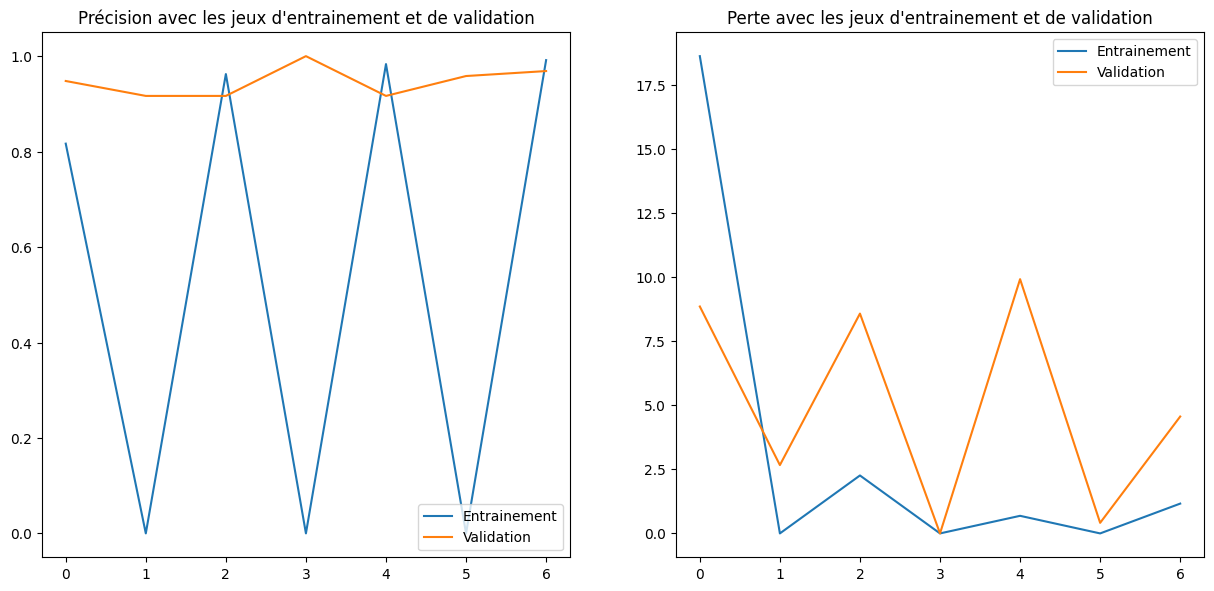

In [17]:
# Extraction des données d'entraînement et de validation de l'historique
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Nombre d'époques
epochs_range = range(len(acc))

# Tracé des graphiques de précision et de perte pour les jeux d'entraînement et de validation
plt.figure(figsize=(15, 15))

# Graphique de précision
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label="Entrainement")  # Précision d'entraînement
plt.plot(epochs_range, val_acc, label='Validation')  # Précision de validation
plt.legend(loc='lower right')
plt.title("Précision avec les jeux d'entrainement et de validation")

# Graphique de perte
plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Entrainement')  # Perte d'entraînement
plt.plot(epochs_range, val_loss, label='Validation')  # Perte de validation
plt.legend(loc='upper right')
plt.title("Perte avec les jeux d'entrainement et de validation")

plt.show()

## Save

In [10]:
# Sauvegarde du modèle entraîné au format h5
model.save("model.h5")

# Chargement du modèle à partir du fichier h5 sauvegardé
loaded_model = load_model("model.h5")

# Test

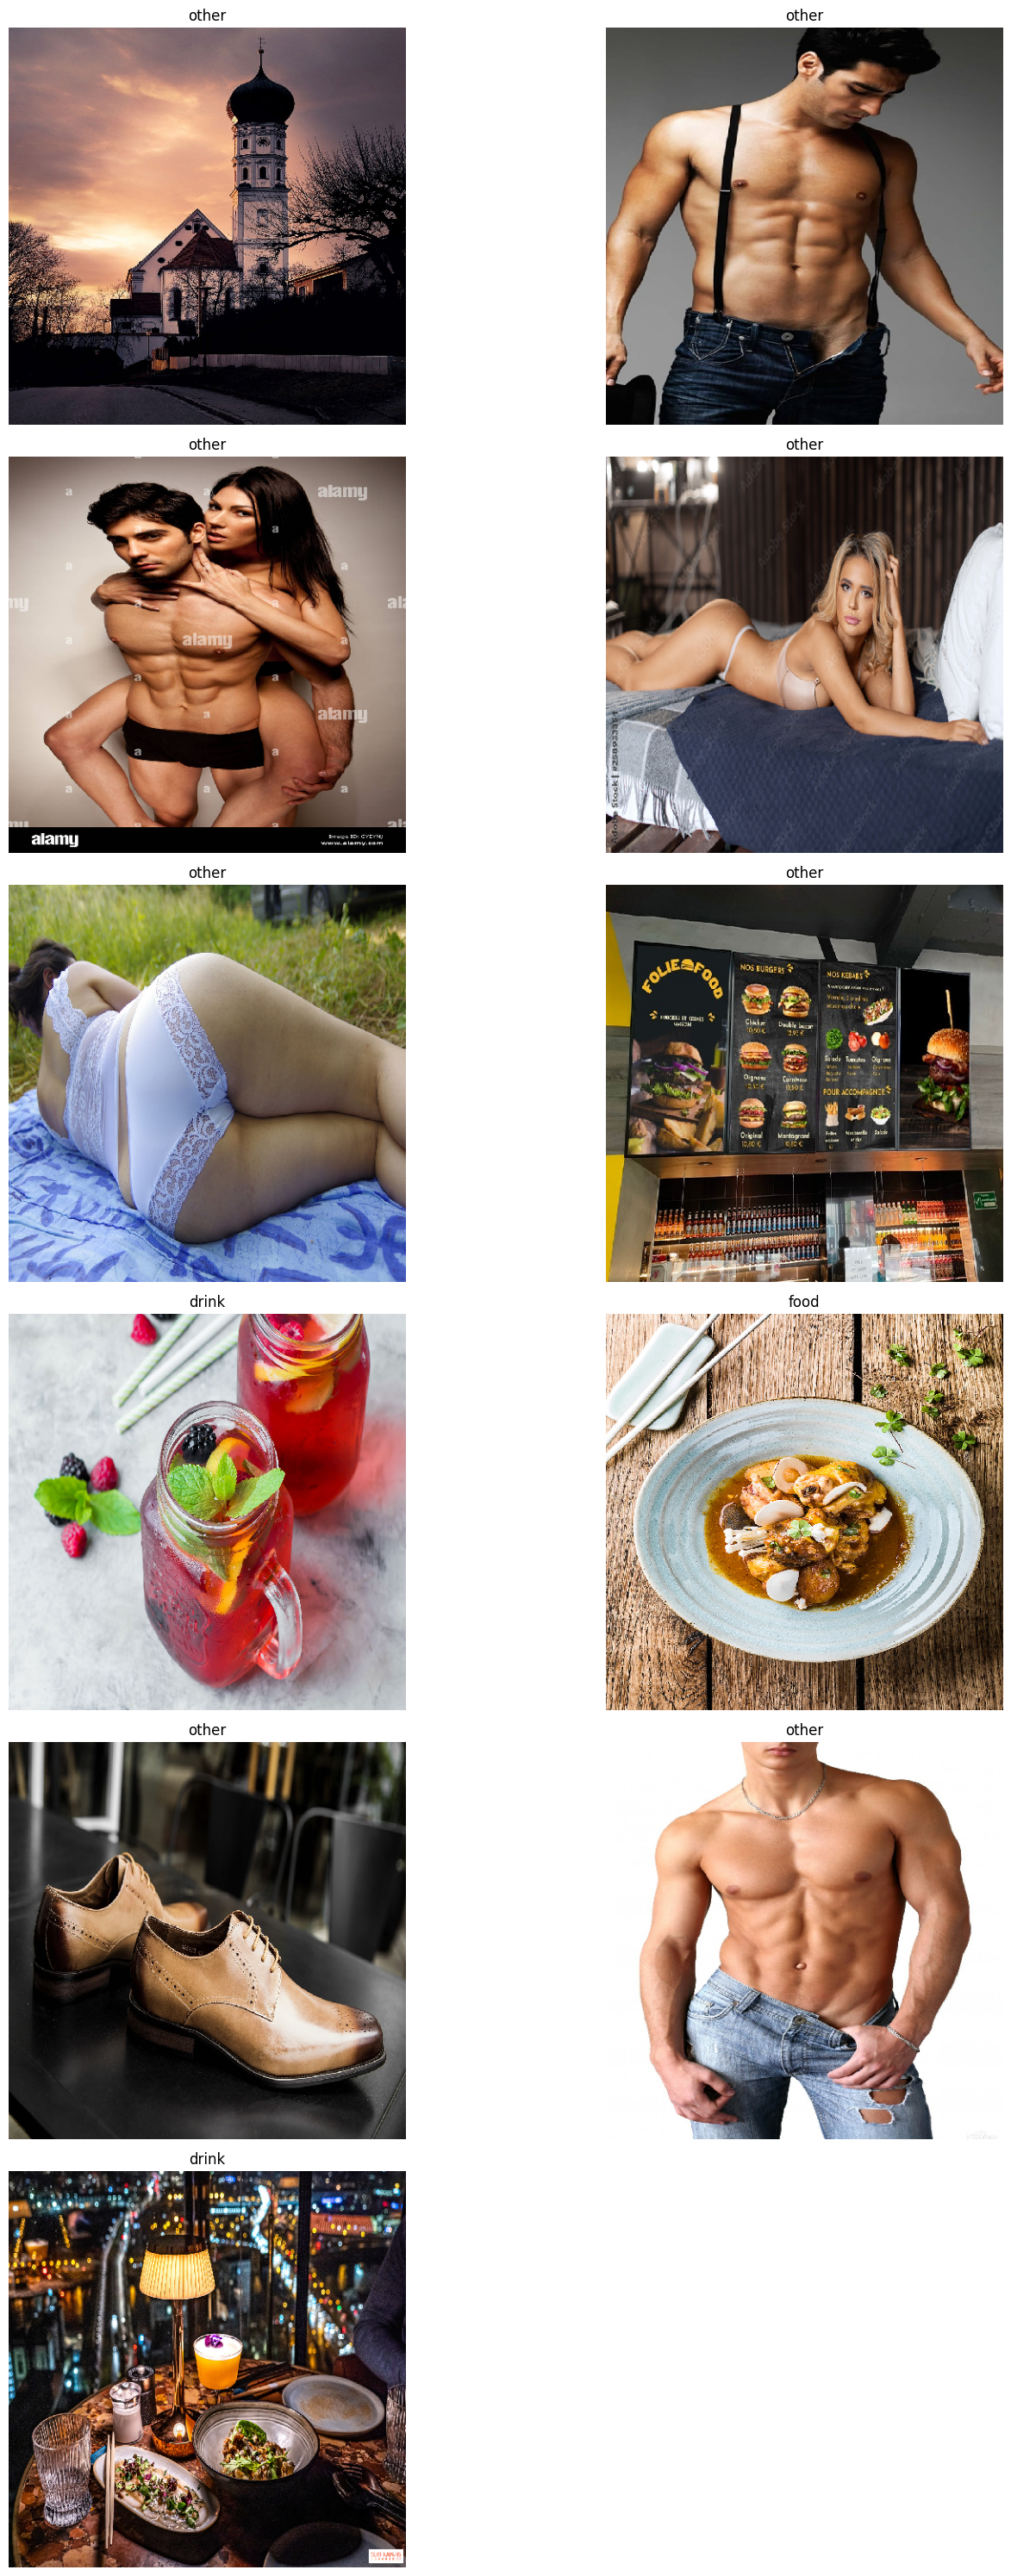

In [18]:
# Chemin du dossier contenant les images de test
folder_path = 'data/test'

# Listes pour stocker les images et les étiquettes prédites
images = []
labels = []

# Taille cible des images
target_size = (480, 480)

# Catégories possibles
categories = ['drink', 'food', 'other']

# Parcours de tous les fichiers dans le dossier
for file in os.listdir(folder_path):
    if file.endswith('.jpg'): 
        img_path = os.path.join(folder_path, file)
        # Chargement et redimensionnement de l'image
        img = image.load_img(img_path, target_size=target_size)
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)

        # Prédiction de la classe de l'image à l'aide du modèle chargé
        prediction = loaded_model.predict(img_array, verbose=0)
        predicted_class = np.argmax(prediction, axis=1)
        predicted_class_label = categories[predicted_class[0]]
        labels.append(predicted_class_label)

        images.append(img)

# Calcul du nombre d'images et de lignes pour le tracé
num_images = len(images)
num_rows = math.ceil(num_images / 2)

# Tracé des images avec les étiquettes prédites
plt.figure(figsize=(15, num_rows * 5))
for i, (img, label) in enumerate(zip(images, labels)):
    plt.subplot(num_rows, 2, i + 1)
    plt.imshow(image.img_to_array(img).astype('uint8'))
    plt.title(label)
    plt.axis('off')

plt.tight_layout()
plt.show()